# Imports


In [78]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
!pip install category_encoders==2.*
import category_encoders as ce 
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# for modeling
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split


In [50]:
df=pd.read_csv('https://raw.githubusercontent.com/Build-Week-Spotify-Song-Suggester-5/Data-Science/master/app/most_popular_spotify_songs.csv')

df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,R&B,Mary J. Blige,Be Without You - Kendu Mix,2YegxR5As7BeQuVp2U6pek,65,0.0830,0.724,246333,0.689,0.000000,D,0.3040,-5.922,Minor,0.1350,146.496,4/4,0.6930
1,R&B,Rihanna,Desperado,6KFaHC9G178beAp7P0Vi5S,63,0.3230,0.685,186467,0.610,0.000000,C,0.1020,-5.221,Minor,0.0439,94.384,3/4,0.3230
2,R&B,Yung Bleu,Ice On My Baby (feat. Kevin Gates) - Remix,6muW8cSjJ3rusKJ0vH5olw,62,0.0675,0.762,199520,0.520,0.000004,F,0.1140,-5.237,Minor,0.0959,75.047,4/4,0.0862
3,R&B,Surfaces,Heaven Falls / Fall on Me,7yHqOZfsXYlicyoMt62yC6,61,0.3600,0.563,240597,0.366,0.002430,B,0.0955,-6.896,Minor,0.1210,85.352,4/4,0.7680
4,R&B,Olivia O'Brien,Love Myself,4XzgjxGKqULifVf7mnDIQK,68,0.5960,0.653,213947,0.621,0.000000,B,0.0811,-5.721,Minor,0.0409,100.006,4/4,0.4660


# Exploratory Data Analysis

In [51]:
df.shape

(75022, 18)

In [52]:
# grouping songs by genre to see how features compare amongst different genres
groupby_genre = df.groupby(['genre'])
genre_musical_attributes = groupby_genre.mean()

genre_musical_attributes

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
genre,,,,,,,,,,,
A Capella,44.000000,0.780000,0.616000,223813.000000,0.298000,0.000000,0.097300,-7.712000,0.027400,82.471000,0.712000
Alternative,51.028906,0.161020,0.541975,232911.767936,0.712900,0.059844,0.195165,-6.503551,0.089687,122.325118,0.449224
Anime,46.419014,0.147398,0.488869,257188.360915,0.788711,0.085839,0.209672,-5.109268,0.072126,131.379421,0.490420
Blues,47.352325,0.340669,0.527623,242691.206287,0.590311,0.082442,0.201720,-9.243054,0.057998,120.335902,0.576963
Children's Music,44.000000,0.474848,0.694619,156495.666667,0.423429,0.085929,0.168976,-11.277571,0.059943,113.821667,0.730762
Children’s Music,53.473438,0.150533,0.525571,232100.387500,0.716429,0.029552,0.196079,-6.307256,0.070634,122.549317,0.440069
Classical,46.649644,0.793293,0.311969,298134.124758,0.229195,0.618121,0.141436,-20.923985,0.049368,105.468918,0.209354
Comedy,44.353333,0.767230,0.551367,252806.036667,0.790793,0.000059,0.721582,-8.217337,0.800496,101.280577,0.387063
Country,48.613067,0.273603,0.576804,216957.487696,0.636474,0.005912,0.179062,-7.352808,0.047017,123.449817,0.542532


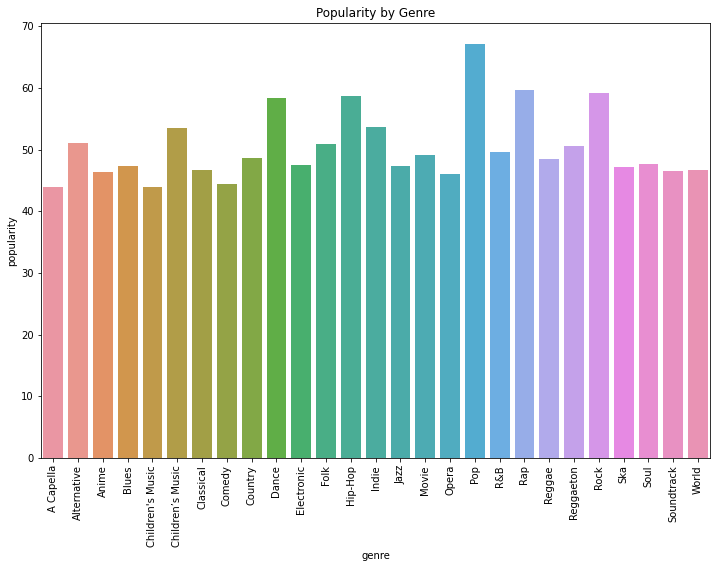

In [53]:
#visualizing Popularity of each Genre:

fig, ax = plt.subplots(figsize=(12,8))
plt.title('Popularity by Genre');
popchart = sns.barplot(x=genre_musical_attributes.index, y=genre_musical_attributes.popularity);
popchart.set_xticklabels(labels = genre_musical_attributes.index, rotation=90);

figure1 = popchart.get_figure()

In [ ]:
#todo - more visualizations by genre 

# Train-Test Split

In [54]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=48)

# Encode Features that need it

**encoding with CE Onehot; difficult to merge back to original dataframe**

In [7]:
####################################################
######################## NOT RUN ################
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)

features_to_encode = ['time_signature', 'mode', 'key']

train_enc = encoder.fit_transform(train[features_to_encode])
val_enc = encoder.fit_transform(val[features_to_encode])
test_enc = encoder.fit_transform(test[features_to_encode]) 

###################################

In [8]:
#############train_enc.head()

,time_signature_1/4,time_signature_4/4,time_signature_3/4,time_signature_5/4,time_signature_0/4,mode_Major,mode_Minor,key_G,key_E,key_C#,key_D,key_A,key_F,key_B,key_D#,key_A#,key_G#,key_C,key_F#
65715,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
10155,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
59994,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
45787,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3674,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


**Defining my own encoder that returns all the features of the original dataframe alongwith the encoded dataset**

In [55]:
class My_encoder(BaseEstimator, TransformerMixin):
   
    def __init__(self,drop = 'first',sparse=False):
        self.encoder = OneHotEncoder(drop = drop,sparse = sparse)
        self.features_to_encode = []
        self.columns = []
    
    def fit(self,X_train,features_to_encode):
        
        data = X_train.copy()
        self.features_to_encode = features_to_encode
        data_to_encode = data[self.features_to_encode]
        self.columns = pd.get_dummies(data_to_encode,drop_first = True).columns
        self.encoder.fit(data_to_encode)
        return self.encoder
    
    def transform(self,X_test):
        
        data = X_test.copy()
        data.reset_index(drop = True,inplace =True)
        data_to_encode = data[self.features_to_encode]
        data_left = data.drop(self.features_to_encode,axis = 1)
        
        data_encoded = pd.DataFrame(self.encoder.transform(data_to_encode),columns = self.columns)
        
        return pd.concat([data_left,data_encoded],axis = 1)

In [60]:
features_to_encode = ['time_signature', 'mode', 'key', 'genre']
enc= My_encoder()
enc.fit(train,features_to_encode)
train_encoded = enc.transform(train)

In [61]:
train_encoded

,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4,mode_Minor,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,genre_Country,genre_Dance,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Movie,genre_Opera,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World
0,Nicholas Britell,Eros,3w5s0j9clwhk0O2uScrNOo,50,0.87200,0.0857,195227,0.280,0.767000,0.0524,-17.998,0.0532,83.982,0.103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Seeb,Grip,3gicyfiEVMGONgzygpWjNT,81,0.33100,0.5980,198075,0.904,0.000000,0.2640,-2.293,0.0507,138.091,0.503,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Lagwagon,Reign,7jLDlShR2ARgNKyAOD94LD,42,0.00351,0.4760,201907,0.948,0.000224,0.1610,-5.150,0.0480,105.467,0.726,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Super Whatevr,Someone Somewhere Somehow,0XvFwux1NYJrKmCYJ7DOjE,42,0.44700,0.4340,215481,0.273,0.025700,0.1260,-14.190,0.0374,125.938,0.395,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Front Bottoms,Flashlight,0xR5ZhiksJK6lMRdI6S2A4,49,0.00129,0.4290,297347,0.865,0.000000,0.1050,-3.751,0.0625,151.043,0.681,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48008,The Black Keys,Strange Times,0dpNxKXHazvWga4MN6z2rn,42,0.02120,0.4530,190320,0.819,0.000822,0.1440,-6.374,0.0329,160.585,0.699,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48009,Ryan Bingham,Beautiful and Kind,0r8Qeq7ay8AAe8gXOrv0yo,43,0.89900,0.5970,196774,0.270,0.000087,0.0953,-10.169,0.0295,98.566,0.347,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48010,Oliver Francis,3 Deep,5dD4Y4KoR2M3rye0dikr70,57,0.04690,0.5220,173431,0.542,0.000000,0.4160,-9.570,0.1850,155.060,0.149,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48011,BANKS,Mother Earth,0riFj45BC3mePSiDhJRWeh,46,0.15200,0.2020,236400,0.335,0.000002,0.1230,-8.771,0.0310,175.769,0.199,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Alternate Hard-encoding approach

In [9]:

# helper function to one hot encode genre
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

time_sig_encoding = { '0/4' : 0, '1/4' : 1, 
                         '3/4' : 3, '4/4' : 4,
                         '5/4' : 5}

key_encoding = { 'A' : 0, 'A#' : 1, 'B' : 2,
                    'C' : 3,  'C#' : 4,  'D' : 5,
                    'D#' : 6, 'E' : 7, 'F' : 8,
                    'F#' : 9, 'G' : 10, 'G#' : 11 }

mode_encoding = { 'Major':0, 'Minor':1}      

df['key'] = df['key'].map(key_encoding)
df['time_signature'] = df['time_signature'].map(time_sig_encoding)
df['mode'] = df['mode'].map(mode_encoding)
df = encode_and_bind(df, 'genre')

In [10]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_A Capella,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,genre_Country,genre_Dance,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Movie,genre_Opera,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World
0,R&B,Mary J. Blige,Be Without You - Kendu Mix,2YegxR5As7BeQuVp2U6pek,65,0.0830,0.724,246333,0.689,0.000000,5,0.3040,-5.922,1,0.1350,146.496,4,0.6930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,R&B,Rihanna,Desperado,6KFaHC9G178beAp7P0Vi5S,63,0.3230,0.685,186467,0.610,0.000000,3,0.1020,-5.221,1,0.0439,94.384,3,0.3230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,R&B,Yung Bleu,Ice On My Baby (feat. Kevin Gates) - Remix,6muW8cSjJ3rusKJ0vH5olw,62,0.0675,0.762,199520,0.520,0.000004,8,0.1140,-5.237,1,0.0959,75.047,4,0.0862,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,R&B,Surfaces,Heaven Falls / Fall on Me,7yHqOZfsXYlicyoMt62yC6,61,0.3600,0.563,240597,0.366,0.002430,2,0.0955,-6.896,1,0.1210,85.352,4,0.7680,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,R&B,Olivia O'Brien,Love Myself,4XzgjxGKqULifVf7mnDIQK,68,0.5960,0.653,213947,0.621,0.000000,2,0.0811,-5.721,1,0.0409,100.006,4,0.4660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [11]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_A Capella,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,genre_Country,genre_Dance,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Movie,genre_Opera,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World
count,75022.000000,75022.000000,75022.000000,7.502200e+04,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000,75022.000000
mean,52.326757,0.286114,0.590045,2.338447e+05,0.609805,0.098790,5.350364,0.188244,-8.127492,0.364760,0.095000,119.785346,3.928634,0.469266,0.000013,0.114820,0.007571,0.020354,0.000280,0.017062,0.020621,0.003999,0.062835,0.104303,0.042334,0.097158,0.098464,0.043947,0.048146,0.004572,0.001053,0.032271,0.064781,0.019288,0.033603,0.037909,0.029378,0.012303,0.037176,0.021914,0.023846
std,8.930855,0.305384,0.168050,8.315542e+04,0.230312,0.249359,3.472272,0.158109,4.636775,0.481366,0.108138,29.795567,0.360540,0.244772,0.003651,0.318806,0.086683,0.141209,0.016729,0.129502,0.142111,0.063110,0.242667,0.305655,0.201352,0.296175,0.297944,0.204979,0.214076,0.067462,0.032433,0.176719,0.246141,0.137535,0.180207,0.190977,0.168865,0.110235,0.189194,0.146402,0.152571
min,41.000000,0.000001,0.058100,3.009300e+04,0.000234,0.000000,0.000000,0.009670,-47.046000,0.000000,0.022200,31.689000,0.000000,0.017600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,0.029300,0.483000,1.910228e+05,0.460250,0.000000,3.000000,0.096200,-9.682750,0.000000,0.035600,95.431750,4.000000,0.274000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,0.158000,0.602000,2.213730e+05,0.638000,0.000015,5.000000,0.123000,-6.979000,0.000000,0.049700,119.048000,4.000000,0.459000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,58.000000,0.485000,0.713000,2.604368e+05,0.792000,0.005727,8.000000,0.228000,-5.198000,1.000000,0.102000,139.997000,4.000000,0.659000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,0.996000,0.986000,5.488000e+06,0.999000,0.994000,11.000000,1.000000,1.585000,1.000000,0.960000,242.903000,5.000000,0.992000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Scale Features for Clustering:


In [62]:
######################################
scaleCols = ['acousticness', 'danceability', 'energy', 'instrumentalness',
             'key', 'liveness', 'loudness', 'speechiness', 'tempo','valence', 'time_signature',
             'mode']
scaler = StandardScaler()
#train_scaled= scaler.fit_transform(df[scaleCols])
#######################################
scaleCols2=['acousticness', 'danceability', 'energy', 'instrumentalness',
              'liveness', 'loudness', 'speechiness', 'tempo','valence', 
             	'time_signature_1/4',	'time_signature_3/4',	'time_signature_4/4',
            	'time_signature_5/4',	'mode_Minor',	'key_A#',	'key_B',	'key_C',
            	'key_C#',	'key_D',	'key_D#',	'key_E','key_F',	'key_F#',	'key_G',	'key_G#']
#########################################

#final list below:

scaleCols3 = ['popularity',	'acousticness',	'danceability',	'duration_ms',	'energy',
              'instrumentalness',	'liveness',	'loudness',	'speechiness',	'tempo',	
              'valence',	'time_signature_1/4',	'time_signature_3/4',	'time_signature_4/4',	
              'time_signature_5/4',	'mode_Minor',	'key_A#',	'key_B',	'key_C',
              'key_C#',	'key_D',	'key_D#', 'key_E',	'key_F',	'key_F#',	'key_G',	
              'key_G#',	'genre_Alternative',	'genre_Anime',	'genre_Blues',
              "genre_Children's Music",	"genre_Children’s Music",	'genre_Classical', 
              'genre_Comedy',	'genre_Country',	'genre_Dance',	'genre_Electronic',	'genre_Folk',
              'genre_Hip-Hop',	'genre_Indie',	'genre_Jazz',	'genre_Movie',	'genre_Opera',	
              'genre_Pop',	'genre_R&B',	'genre_Rap',	'genre_Reggae',	'genre_Reggaeton',
              'genre_Rock',	'genre_Ska',	'genre_Soul',	'genre_Soundtrack',	'genre_World']

train_scaled = scaler.fit_transform(train_encoded[scaleCols3])

In [63]:
train_scaled

array([[-0.25935212,  1.91665122, -2.98685633, ..., -0.19815378,
         6.59215302, -0.15567155],
       [ 3.21956341,  0.14883313,  0.04980466, ..., -0.19815378,
        -0.15169551, -0.15567155],
       [-1.15713677, -0.92130134, -0.67335099, ..., -0.19815378,
        -0.15169551, -0.15567155],
       ...,
       [ 0.52620945, -0.77951644, -0.40068575, ..., -0.19815378,
        -0.15169551, -0.15567155],
       [-0.70824444, -0.43608265, -2.29748746, ..., -0.19815378,
        -0.15169551, -0.15567155],
       [-0.59602136, -0.19427389,  0.13278974, ..., -0.19815378,
        -0.15169551, -0.15567155]])

In [67]:
train_scaled_df = pd.DataFrame(train_scaled, columns=scaleCols3)
print(train_scaled_df.shape)
train_scaled_df.head()

(48013, 53)


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4,mode_Minor,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,genre_Country,genre_Dance,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Movie,genre_Opera,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World
0,-0.259352,1.916651,-2.986856,-0.454603,-1.425094,2.658536,-0.859445,-2.108236,-0.389000,-1.200244,-1.495531,13.372508,-0.269675,-3.217651,-0.122075,-0.75878,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,2.865661,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,6.592153,-0.155672
1,3.219563,0.148833,0.049805,-0.421342,1.276434,-0.398629,0.478628,1.254850,-0.412328,0.614084,0.136646,-0.074780,-0.269675,0.310786,-0.122075,-0.75878,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,3.450612,-0.299489,-0.274048,-0.348960,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,2.936298,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,-0.151696,-0.155672
2,-1.157137,-0.921301,-0.673351,-0.376589,1.466926,-0.397736,-0.172702,0.643049,-0.437522,-0.479831,1.046584,-0.074780,-0.269675,0.310786,-0.122075,-0.75878,-0.264438,-0.29771,-0.36432,2.900744,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,-0.348960,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,8.866992,-0.198154,-0.151696,-0.155672
3,-1.157137,0.527885,-0.922306,-0.218063,-1.455400,-0.296192,-0.394028,-1.292787,-0.536433,0.206582,-0.304042,-0.074780,-0.269675,0.310786,-0.122075,-0.75878,-0.264438,-0.29771,-0.36432,-0.344739,3.042531,-0.174955,-0.289804,-0.299489,-0.274048,-0.348960,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,7.672456,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,-0.151696,-0.155672
4,-0.371575,-0.928556,-0.951944,0.738021,1.107588,-0.398629,-0.526824,0.942632,-0.302219,1.048378,0.862964,-0.074780,-0.269675,0.310786,-0.122075,-0.75878,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,-0.348960,-0.272199,2.780793,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,-0.151696,-0.155672


In [68]:
train_encoded

,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4,mode_Minor,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,genre_Country,genre_Dance,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Movie,genre_Opera,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World
0,Nicholas Britell,Eros,3w5s0j9clwhk0O2uScrNOo,50,0.87200,0.0857,195227,0.280,0.767000,0.0524,-17.998,0.0532,83.982,0.103,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Seeb,Grip,3gicyfiEVMGONgzygpWjNT,81,0.33100,0.5980,198075,0.904,0.000000,0.2640,-2.293,0.0507,138.091,0.503,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Lagwagon,Reign,7jLDlShR2ARgNKyAOD94LD,42,0.00351,0.4760,201907,0.948,0.000224,0.1610,-5.150,0.0480,105.467,0.726,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Super Whatevr,Someone Somewhere Somehow,0XvFwux1NYJrKmCYJ7DOjE,42,0.44700,0.4340,215481,0.273,0.025700,0.1260,-14.190,0.0374,125.938,0.395,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The Front Bottoms,Flashlight,0xR5ZhiksJK6lMRdI6S2A4,49,0.00129,0.4290,297347,0.865,0.000000,0.1050,-3.751,0.0625,151.043,0.681,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48008,The Black Keys,Strange Times,0dpNxKXHazvWga4MN6z2rn,42,0.02120,0.4530,190320,0.819,0.000822,0.1440,-6.374,0.0329,160.585,0.699,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48009,Ryan Bingham,Beautiful and Kind,0r8Qeq7ay8AAe8gXOrv0yo,43,0.89900,0.5970,196774,0.270,0.000087,0.0953,-10.169,0.0295,98.566,0.347,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48010,Oliver Francis,3 Deep,5dD4Y4KoR2M3rye0dikr70,57,0.04690,0.5220,173431,0.542,0.000000,0.4160,-9.570,0.1850,155.060,0.149,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48011,BANKS,Mother Earth,0riFj45BC3mePSiDhJRWeh,46,0.15200,0.2020,236400,0.335,0.000002,0.1230,-8.771,0.0310,175.769,0.199,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
train_encoded['index']=np.arange(1, len(train2)+1)
train_scaled_df['index'] = np.arange(1, len(train2)+1)

In [70]:
train_scaled_df.head(1)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4,mode_Minor,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,genre_Country,genre_Dance,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Movie,genre_Opera,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World,index
0,-0.259352,1.916651,-2.986856,-0.454603,-1.425094,2.658536,-0.859445,-2.108236,-0.389,-1.200244,-1.495531,13.372508,-0.269675,-3.217651,-0.122075,-0.75878,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,2.865661,-0.272199,-0.35961,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,6.592153,-0.155672,1


In [74]:
train_ids = train_encoded[['index','artist_name','track_name','track_id']]

train_ids

,index,artist_name,track_name,track_id
0,1,Nicholas Britell,Eros,3w5s0j9clwhk0O2uScrNOo
1,2,Seeb,Grip,3gicyfiEVMGONgzygpWjNT
2,3,Lagwagon,Reign,7jLDlShR2ARgNKyAOD94LD
3,4,Super Whatevr,Someone Somewhere Somehow,0XvFwux1NYJrKmCYJ7DOjE
4,5,The Front Bottoms,Flashlight,0xR5ZhiksJK6lMRdI6S2A4
...,...,...,...,...
48008,48009,The Black Keys,Strange Times,0dpNxKXHazvWga4MN6z2rn
48009,48010,Ryan Bingham,Beautiful and Kind,0r8Qeq7ay8AAe8gXOrv0yo
48010,48011,Oliver Francis,3 Deep,5dD4Y4KoR2M3rye0dikr70
48011,48012,BANKS,Mother Earth,0riFj45BC3mePSiDhJRWeh


In [75]:
train_new = pd.merge(train_scaled_df, train_ids, how='left', on='index')
train_new

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature_1/4,time_signature_3/4,time_signature_4/4,time_signature_5/4,mode_Minor,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,genre_Alternative,genre_Anime,genre_Blues,genre_Children's Music,genre_Children’s Music,genre_Classical,genre_Comedy,genre_Country,genre_Dance,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Indie,genre_Jazz,genre_Movie,genre_Opera,genre_Pop,genre_R&B,genre_Rap,genre_Reggae,genre_Reggaeton,genre_Rock,genre_Ska,genre_Soul,genre_Soundtrack,genre_World,index,artist_name,track_name,track_id
0,-0.259352,1.916651,-2.986856,-0.454603,-1.425094,2.658536,-0.859445,-2.108236,-0.389000,-1.200244,-1.495531,13.372508,-0.269675,-3.217651,-0.122075,-0.758780,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,2.865661,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,6.592153,-0.155672,1,Nicholas Britell,Eros,3w5s0j9clwhk0O2uScrNOo
1,3.219563,0.148833,0.049805,-0.421342,1.276434,-0.398629,0.478628,1.254850,-0.412328,0.614084,0.136646,-0.074780,-0.269675,0.310786,-0.122075,-0.758780,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,3.450612,-0.299489,-0.274048,-0.348960,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,2.936298,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,-0.151696,-0.155672,2,Seeb,Grip,3gicyfiEVMGONgzygpWjNT
2,-1.157137,-0.921301,-0.673351,-0.376589,1.466926,-0.397736,-0.172702,0.643049,-0.437522,-0.479831,1.046584,-0.074780,-0.269675,0.310786,-0.122075,-0.758780,-0.264438,-0.29771,-0.36432,2.900744,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,-0.348960,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,8.866992,-0.198154,-0.151696,-0.155672,3,Lagwagon,Reign,7jLDlShR2ARgNKyAOD94LD
3,-1.157137,0.527885,-0.922306,-0.218063,-1.455400,-0.296192,-0.394028,-1.292787,-0.536433,0.206582,-0.304042,-0.074780,-0.269675,0.310786,-0.122075,-0.758780,-0.264438,-0.29771,-0.36432,-0.344739,3.042531,-0.174955,-0.289804,-0.299489,-0.274048,-0.348960,-0.272199,-0.359610,-0.088245,-0.143065,-0.019366,7.672456,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,-0.151696,-0.155672,4,Super Whatevr,Someone Somewhere Somehow,0XvFwux1NYJrKmCYJ7DOjE
4,-0.371575,-0.928556,-0.951944,0.738021,1.107588,-0.398629,-0.526824,0.942632,-0.302219,1.048378,0.862964,-0.074780,-0.269675,0.310786,-0.122075,-0.758780,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,-0.348960,-0.272199,2.780793,-0.088245,-0.143065,-0.019366,-0.130336,-0.148064,-0.061173,-0.257794,-0.340565,-0.210705,-0.328207,-0.330499,-0.214504,-0.22441,-0.069227,-0.032609,-0.181732,-0.263807,-0.139616,-0.186149,-0.198437,-0.173305,-0.112778,-0.198154,-0.151696,-0.155672,5,The Front Bottoms,Flashlight,0xR5ZhiksJK6lMRdI6S2A4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48008,-1.157137,-0.863496,-0.809684,-0.511910,0.908437,-0.395353,-0.280204,0.380940,-0.578423,1.368330,0.936412,-0.074780,-0.269675,0.310786,-0.122075,1.317906,-0.264438,-0.29771,-0.36432,-0.344739,-0.328674,-0.174955,-0.289804,-0.299489,-0.274048,-

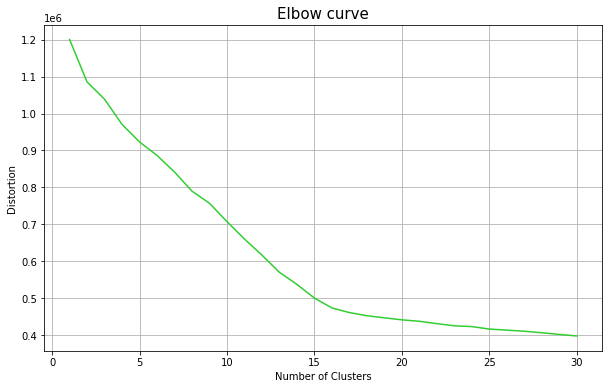

In [76]:
clusterCols = ['acousticness', 'danceability', 'energy', 'instrumentalness',
              'liveness', 'loudness', 'speechiness', 'tempo','valence', 
             	'time_signature_1/4',	'time_signature_3/4',	'time_signature_4/4',
            	'time_signature_5/4',	'mode_Minor',	'key_A#',	'key_B',	'key_C',
            	'key_C#',	'key_D',	'key_D#',	'key_E','key_F',	'key_F#',	'key_G',	'key_G#'] #variables to cluster

distortion = list()
for k in range(1, 31): #started with range [1, 51] and narrowed down to this range 
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(train_new.loc[:, clusterCols])
    distortion.append(kmeans.inertia_) #append distortion value to list

#plot elbow curves 
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), distortion, c = 'limegreen', label = 'distortion')
plt.xlabel('Number of Clusters', fontsize = 10)
plt.ylabel('Distortion', fontsize = 10)
plt.grid(True)
plt.title('Elbow curve', fontsize = 15)
plt.show()

based on the elbow test, it looks like at about 15-25 clusters, we achieve diminishing returns.

# Modeling with Nearest Neighbors

In [79]:
neigh = NearestNeighbors(n_neighbors=15)
features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
              'liveness', 'loudness', 'speechiness', 'tempo','valence', 
             	'time_signature_1/4',	'time_signature_3/4',	'time_signature_4/4',
            	'time_signature_5/4',	'mode_Minor',	'key_A#',	'key_B',	'key_C',
            	'key_C#',	'key_D',	'key_D#',	'key_E','key_F',	'key_F#',	'key_G',	'key_G#']
X = train_new[features].values

neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=1.0)

In [80]:
X.shape

(48013, 25)

In [82]:
# test on 1 song
test_song = X[10000]

distance, neighbors = neigh.kneighbors(np.array([test_song]))
distance, neighbors

(array([[0.        , 0.58625134, 0.58810863, 0.6186691 , 0.69482203,
         0.75026464, 0.7633188 , 0.8040146 , 0.82219461, 0.82834324,
         0.83799405, 0.90119726, 0.90310742, 0.92947901, 0.94582818]]),
 array([[10000, 14049, 26446, 32952, 34477, 10590, 42012, 11283, 32187,
         47815,  8254, 43400, 42605, 25559, 16826]]))

In [85]:
train_new.iloc[10000]

popularity                             -0.259352
acousticness                           -0.932701
danceability                           -0.193223
duration_ms                             0.798587
energy                                   1.40199
instrumentalness                       -0.398594
liveness                               -0.450941
loudness                                0.953553
speechiness                            -0.558828
tempo                                  -0.296115
valence                                -0.140825
time_signature_1/4                    -0.0747803
time_signature_3/4                     -0.269675
time_signature_4/4                      0.310786
time_signature_5/4                     -0.122075
mode_Minor                               1.31791
key_A#                                 -0.264438
key_B                                   -0.29771
key_C                                   -0.36432
key_C#                                 -0.344739
key_D               

In [83]:
song_list = []
for item in neighbors[0][1:]: # this way excludes itself
    row = df.iloc[item]
    # print(f'Artist: {row.artist_name} - Track: {row.track_name}')
    song_list.append((row.artist_name, row.track_name))
print(song_list)

[('Babyface', 'When Can I See You'), ('J.J. Cale', 'Crazy Mama'), ('Drake', 'Jaded'), ('Machine Gun Kelly', 'At My Best (feat. Hailee Steinfeld)'), ('Melanie Martinez', 'Pity Party'), ('Kodak Black', 'The Recipe'), ('Joe', 'I Wanna Know'), ('Colbie Caillat', 'You Got Me'), ('Fonseca', 'Te Mando Flores'), ('KAYTRANADA', 'LEAVE ME ALONE'), ('$uicideBoy$', 'Iron Veil'), ('KEY', 'Cable Guy (feat. Jay Critch)'), ('Charlie Parr', 'Rocky Raccoon'), ('Bobby V.', 'Anonymous - Main')]
